In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.special
from scipy.optimize import minimize
from scipy.stats import norm 
import pymc as pm
import arviz as az

In [2]:
def f(x):
    return -1*2*np.sin(x+1)*3*x

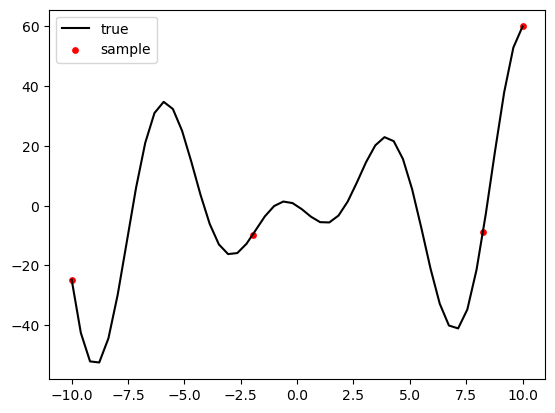

In [4]:
x=np.linspace(-10,10,50) #
x_new=np.linspace(-10,10,50).reshape(50,1)
plt.plot(x,f(x),color='k',label='true')
x_=20*np.random.rand(2,1)-10
x_=np.vstack((np.array(-10),np.array(10),x_))
y_=f(x_)
plt.scatter(x_,y_,s=15,c='r',label='sample')
plt.legend()
plt.show()

In [5]:
def plot(i,x,mean,sigma,xnew,func,next_point=None,color='b'):
    var=np.sqrt(sigma)
    plt.scatter(x,func(x))
    if next_point!= None:
        plt.scatter(next_point,func(next_point),s=20,c='r',label='next point')
    plt.plot(xnew,mean,'--',label=f'iter{i}',color=color)
    plt.plot(xnew,mean+2*var,color=color)
    plt.plot(xnew,mean-2*var,color=color)
    plt.legend(loc='upper left')
    plt.show()

In [6]:
def truth_plot(x,func):
    plt.plot(x,func(x),'k',label='truth')

In [9]:
class gaussprocess():
    def __init__(self,func,x,xnew):
        self.func=func
        self.x=x
        self.y=func(x)
        self.xnew=xnew
        
    def iteratate(self,n_iter,add_point=True,mode='MCMC'):                
        #ax = plt.gca()
        self.mode=mode
        for i in range(n_iter):
            print('iteration:',i+1)
            truth_plot(np.linspace(-10,10,100),self.func)
            if add_point==False:
                next_point=None
            elif add_point==True:
                next_point=(20*np.random.rand(1,1)-10).reshape(1,1)
                self.x=np.vstack((self.x,next_point))
                self.y=self.func(self.x)
            with pm.Model():
                theta0=pm.Gamma("theta0",alpha=1,beta=1)
                theta=pm.Gamma("theta",alpha=1,beta=1)
                nu=pm.HalfCauchy('Nu',beta=1)
                mean=pm.gp.mean.Constant(self.y.mean())
                cov=theta0**2*pm.gp.cov.Matern52(1,ls=theta)
                gp=pm.gp.Marginal(mean_func=mean,cov_func=cov)
                gp.marginal_likelihood('gp',X=self.x,y=self.y,sigma=nu)
                self.Mean,self.Sigma = self.pred(gp)
                if self.mode =='OPT':
                    plot(i+2,self.x,self.Mean,self.Sigma,self.xnew,self.func,next_point=next_point)
                elif self.mode=='MCMC':
                    for j in range(len(self.Mean)):
                        plot(i*(len(self.Mean)-1)+2,self.x,self.Mean[i],self.Sigma,
                            self.xnew,self.func,next_point=next_point)
    def pred(self,gp):
        Mean=[]
        sigma=[]
        if self.mode == 'OPT':
            trace=pm.sample(chains=1,return_inferencedata=False)
            point=trace.point(1)
            print(point)
            for i in range(len(self.xnew)):
                m,sig = gp.predict(Xnew=self.xnew[i].reshape(1,1),point=point,diag=False,pred_noise=True)
                print(m,sig)
                Mean.append(m[0][0])
                sigma.append(sig[0])
        elif self.mode == 'MCMC':
            trace=pm.sample(draws=5,chains=4,tune=1000,return_inferencedata=False)
            for pt in trace.points():
            #az.plot_trace(pt)
                mmean=[]
                sigmaa=[]
                for i in range(len(self.xnew)):
                    m,sig = gp.predict(Xnew=self.xnew[i].reshape(1,1),point=pt,diag=True)
                    #print(m,sig)
                    mmean.append(m[0])
                    sigmaa.append(sig[0])
                Mean.append(mmean)
                sigma.append(sigmaa)
        return np.array(Mean),np.array(sigma).reshape((len(sigma),))  

In [10]:
gauss=gaussprocess(f,x_,x_new)
    

iteration: 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


{'theta0_log__': 2.7325271637643738, 'theta_log__': 3.4284009641581954, 'Nu_log__': -5.029003127020385, 'theta0': 15.371684739834462, 'theta': 30.82730934469887, 'Nu': 0.006545332184195808}
[[-24.72627757 -24.72627757 -24.72627757 -24.72627757 -24.72627757]] [[8.66824504e-05]]
[[-21.06434685 -21.06434685 -21.06434685 -21.06434685 -21.06434685]] [[0.00487099]]
[[-17.5789904 -17.5789904 -17.5789904 -17.5789904 -17.5789904]] [[0.01690968]]
[[-14.29591582 -14.29591582 -14.29591582 -14.29591582 -14.29591582]] [[0.03300073]]
[[-11.24154165 -11.24154165 -11.24154165 -11.24154165 -11.24154165]] [[0.05038588]]
[[-8.44254457 -8.44254457 -8.44254457 -8.44254457 -8.44254457]] [[0.06680584]]
[[-5.9254067 -5.9254067 -5.9254067 -5.9254067 -5.9254067]] [[0.08053102]]
[[-3.71596184 -3.71596184 -3.71596184 -3.71596184 -3.71596184]] [[0.09036839]]
[[-1.83893937 -1.83893937 -1.83893937 -1.83893937 -1.83893937]] [[0.09564572]]
[[-0.31750449 -0.31750449 -0.31750449 -0.31750449 -0.31750449]] [[0.09617504]]
[

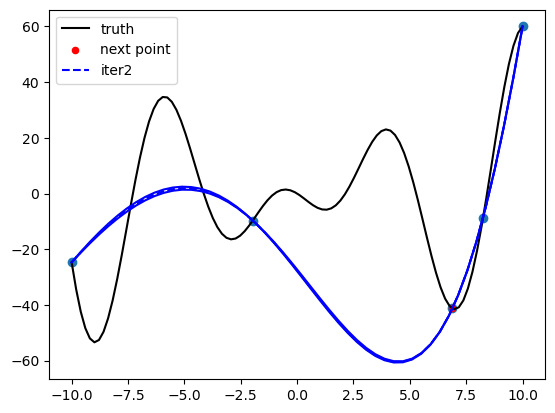

iteration: 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


{'theta0_log__': 2.531397749883715, 'theta_log__': 4.102245855415688, 'Nu_log__': -6.8069653511196835, 'theta0': 12.571065067048673, 'theta': 60.475955447210154, 'Nu': 0.001106044268273023}
[[-24.7364803 -24.7364803 -24.7364803 -24.7364803 -24.7364803 -24.7364803]] [[3.44664806e-06]]
[[-41.67027875 -41.67027875 -41.67027875 -41.67027875 -41.67027875
  -41.67027875]] [[0.00014658]]
[[-56.92927483 -56.92927483 -56.92927483 -56.92927483 -56.92927483
  -56.92927483]] [[0.00049628]]
[[-70.42884365 -70.42884365 -70.42884365 -70.42884365 -70.42884365
  -70.42884365]] [[0.00094729]]
[[-82.08712827 -82.08712827 -82.08712827 -82.08712827 -82.08712827
  -82.08712827]] [[0.00141516]]
[[-91.82775462 -91.82775462 -91.82775462 -91.82775462 -91.82775462
  -91.82775462]] [[0.00183588]]
[[-99.5825511 -99.5825511 -99.5825511 -99.5825511 -99.5825511 -99.5825511]] [[0.002165]]
[[-105.29427302 -105.29427302 -105.29427302 -105.29427302 -105.29427302
  -105.29427302]] [[0.00237607]]
[[-108.91933568 -108.91933

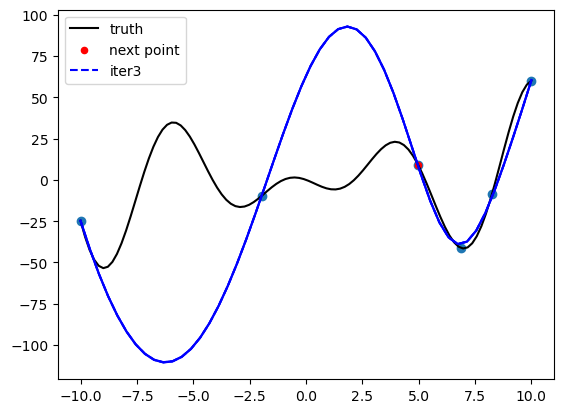

iteration: 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


{'theta0_log__': 2.5380163008137147, 'theta_log__': 4.209033399466224, 'Nu_log__': -7.683159852993542, 'theta0': 12.654543249007267, 'theta': 67.29146439881325, 'Nu': 0.00046051742992116087}
[[-24.73562324 -24.73562324 -24.73562324 -24.73562324 -24.73562324
  -24.73562324 -24.73562324]] [[1.42414338e-06]]
[[-42.4535283 -42.4535283 -42.4535283 -42.4535283 -42.4535283 -42.4535283
  -42.4535283]] [[8.97027516e-05]]
[[-58.37699654 -58.37699654 -58.37699654 -58.37699654 -58.37699654
  -58.37699654 -58.37699654]] [[0.00030479]]
[[-72.42609047 -72.42609047 -72.42609047 -72.42609047 -72.42609047
  -72.42609047 -72.42609047]] [[0.00058138]]
[[-84.52401648 -84.52401648 -84.52401648 -84.52401648 -84.52401648
  -84.52401648 -84.52401648]] [[0.00086736]]
[[-94.59982754 -94.59982754 -94.59982754 -94.59982754 -94.59982754
  -94.59982754 -94.59982754]] [[0.00112353]]
[[-102.591131 -102.591131 -102.591131 -102.591131 -102.591131 -102.591131
  -102.591131]] [[0.00132291]]
[[-108.44680102 -108.44680102 -

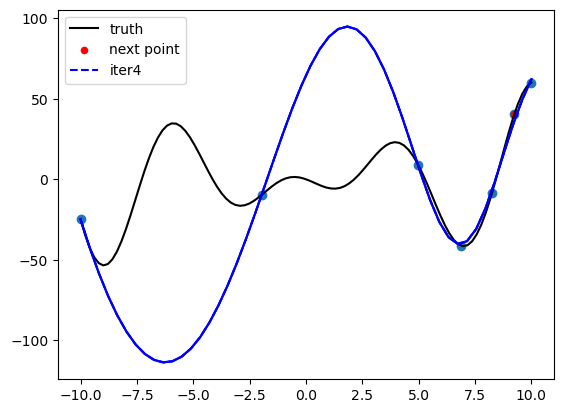

iteration: 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


{'theta0_log__': 2.4603031019056427, 'theta_log__': 4.534378416823494, 'Nu_log__': -7.932814362149656, 'theta0': 11.708359828383134, 'theta': 93.1655871411069, 'Nu': 0.0003587752672005157}
[[-24.6586625 -24.6586625 -24.6586625 -24.6586625 -24.6586625 -24.6586625
  -24.6586625 -24.6586625]] [[1.25720079e-06]]
[[-15.05877011 -15.05877011 -15.05877011 -15.05877011 -15.05877011
  -15.05877011 -15.05877011 -15.05877011]] [[6.21655868e-06]]
[[-6.67482337 -6.67482337 -6.67482337 -6.67482337 -6.67482337 -6.67482337
  -6.67482337 -6.67482337]] [[1.71671079e-05]]
[[0.45942048 0.45942048 0.45942048 0.45942048 0.45942048 0.45942048
  0.45942048 0.45942048]] [[2.88779025e-05]]
[[6.31742392 6.31742392 6.31742392 6.31742392 6.31742392 6.31742392
  6.31742392 6.31742392]] [[3.80221959e-05]]
[[10.88386004 10.88386004 10.88386004 10.88386004 10.88386004 10.88386004
  10.88386004 10.88386004]] [[4.29144973e-05]]
[[14.15861012 14.15861012 14.15861012 14.15861012 14.15861012 14.15861012
  14.15861012 14.15

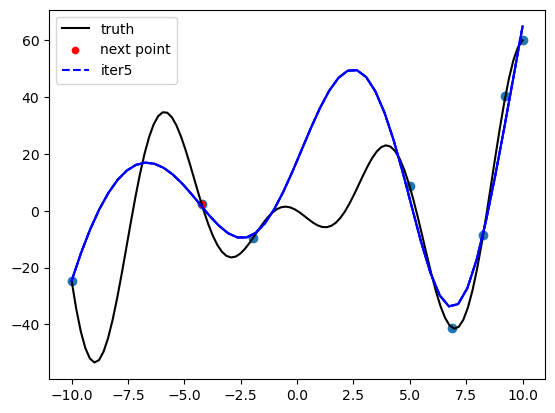

iteration: 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


{'theta0_log__': 2.4248253454348423, 'theta_log__': 4.794970860636928, 'Nu_log__': -9.061762692322603, 'theta0': 11.30025560568784, 'theta': 120.90085875770617, 'Nu': 0.0001160182916881244}
[[-24.56042808 -24.56042808 -24.56042808 -24.56042808 -24.56042808
  -24.56042808 -24.56042808 -24.56042808 -24.56042808]] [[1.02623976e-06]]
[[-16.96277988 -16.96277988 -16.96277988 -16.96277988 -16.96277988
  -16.96277988 -16.96277988 -16.96277988 -16.96277988]] [[2.26967303e-06]]
[[-10.2973494 -10.2973494 -10.2973494 -10.2973494 -10.2973494 -10.2973494
  -10.2973494 -10.2973494 -10.2973494]] [[5.27111988e-06]]
[[-4.58323267 -4.58323267 -4.58323267 -4.58323267 -4.58323267 -4.58323267
  -4.58323267 -4.58323267 -4.58323267]] [[8.57063421e-06]]
[[0.16561908 0.16561908 0.16561908 0.16561908 0.16561908 0.16561908
  0.16561908 0.16561908 0.16561908]] [[1.12301005e-05]]
[[3.94314383 3.94314383 3.94314383 3.94314383 3.94314383 3.94314383
  3.94314383 3.94314383 3.94314383]] [[1.27587761e-05]]
[[6.75391014

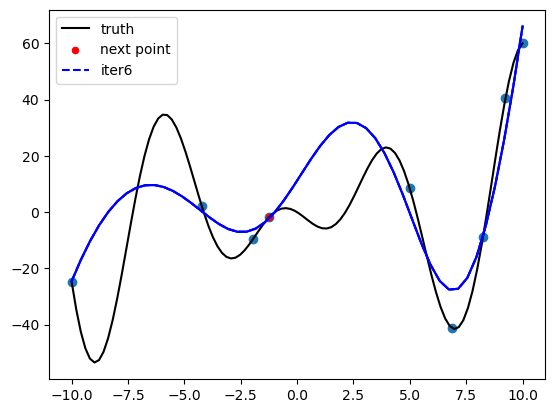

In [11]:
gauss.iteratate(5,add_point=True,mode='OPT')    